## Импорт библиотек

In [2]:
import pandas as pd
from scipy.stats import shapiro, mannwhitneyu

import seaborn as sns
import matplotlib.pyplot as plt

## Настройка фона

In [3]:
sns.set(font_scale = 1,
        style = 'whitegrid',
       rc = {'figure.figsize' : (10, 7)})

## Считывание и структура данных

In [4]:
users = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-d-pak/statistic/lesson 10/ab_users_data.csv')
orders = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-d-pak/statistic/lesson 10/ab_orders.csv')
products = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-d-pak/statistic/lesson 10/ab_products.csv')

In [5]:
users.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1


In [6]:
users.shape

(4337, 6)

In [7]:
users.dtypes

user_id      int64
order_id     int64
action      object
time        object
date        object
group        int64
dtype: object

In [8]:
users.isna().sum()

user_id     0
order_id    0
action      0
time        0
date        0
group       0
dtype: int64

In [9]:
users.time = pd.to_datetime(users.time)
users.date = pd.to_datetime(users.date)

In [10]:
orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


In [11]:
orders.shape

(4123, 3)

In [12]:
orders.dtypes

order_id          int64
creation_time    object
product_ids      object
dtype: object

In [13]:
orders.isna().sum()

order_id         0
creation_time    0
product_ids      0
dtype: int64

In [14]:
orders.creation_time = pd.to_datetime(orders.creation_time)

In [15]:
products.head()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


In [16]:
products.shape

(87, 3)

In [17]:
products.dtypes

product_id      int64
name           object
price         float64
dtype: object

## Выбор метрик  
Для оценки пользы для бизнеса я буду сравнивать выручку на пользователя.  
Для оценки пользы для юзеров - количество заказов на пользователя (если новая система работает, юзеры лучше находят необходимые товары и делают больше заказов).

## Решение

### 1. RPU

Нулевая гипотеза: новая система рекомендаций не повлияла на выручку на пользователя, значимых различий между тестовой и контрольной группой нет.  
Альтернативная гипотеза: новая система повлияла на выручку на пользователя, есть статистически значимые различия между группами.

Объединяю датафрейм с юзерами и датафрейм с заказами:

In [18]:
df = users.merge(orders, on='order_id')
df

,user_id,order_id,action,time,date,group,creation_time,product_ids
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19,"{75, 22, 53, 84}"
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,2022-08-26 00:02:21,"{56, 76, 39}"
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0,2022-08-26 00:02:27,"{76, 34, 41, 38}"
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0,2022-08-26 00:02:56,"{74, 6}"
4,966,1258,cancel_order,2022-08-26 00:08:25.486419,2022-08-26,0,2022-08-26 00:02:56,"{74, 6}"
...,...,...,...,...,...,...,...,...
4332,990,59422,create_order,2022-09-08 23:13:03.000000,2022-09-08,1,2022-09-08 23:13:03,"{84, 8, 24}"
4333,1418,59439,create_order,2022-09-08 23:18:05.000000,2022-09-08,1,2022-09-08 23:18:05,"{9, 25, 75, 30, 6}"
4334,1605,59464,create_order,2022-09-08 23:22:27.000000,2022-09-08,0,2022-09-08 23:22:27,"{60, 41, 46}"
4335,1461,59487,create_order,2022-09-08 23:29:06.000000,2022-09-08,0,2022-09-08 23:29:06,"{9, 62, 77}"


Убираю лишнюю колонку с временем:

In [19]:
df = df.drop(columns={'time'})

In [20]:
df = df.query('action != "cancel_order"')
df

,user_id,order_id,action,date,group,creation_time,product_ids
0,964,1255,create_order,2022-08-26,0,2022-08-26 00:00:19,"{75, 22, 53, 84}"
1,965,1256,create_order,2022-08-26,1,2022-08-26 00:02:21,"{56, 76, 39}"
2,964,1257,create_order,2022-08-26,0,2022-08-26 00:02:27,"{76, 34, 41, 38}"
3,966,1258,create_order,2022-08-26,0,2022-08-26 00:02:56,"{74, 6}"
5,967,1259,create_order,2022-08-26,1,2022-08-26 00:03:37,"{20, 45, 67, 26}"
...,...,...,...,...,...,...,...
4332,990,59422,create_order,2022-09-08,1,2022-09-08 23:13:03,"{84, 8, 24}"
4333,1418,59439,create_order,2022-09-08,1,2022-09-08 23:18:05,"{9, 25, 75, 30, 6}"
4334,1605,59464,create_order,2022-09-08,0,2022-09-08 23:22:27,"{60, 41, 46}"
4335,1461,59487,create_order,2022-09-08,0,2022-09-08 23:29:06,"{9, 62, 77}"


Переименовываю переменные для удобства:

In [21]:
df.group = df.group.apply(lambda x: 'control' if x == 0 else 'experimental')

Разбиваю строку с id заказанных продуктов, создаю список:

In [22]:
df.product_ids = df.product_ids.apply(lambda x: x.replace('{', '').replace('}', '').split(', '))
df.head()

,user_id,order_id,action,date,group,creation_time,product_ids
0,964,1255,create_order,2022-08-26,control,2022-08-26 00:00:19,"[75, 22, 53, 84]"
1,965,1256,create_order,2022-08-26,experimental,2022-08-26 00:02:21,"[56, 76, 39]"
2,964,1257,create_order,2022-08-26,control,2022-08-26 00:02:27,"[76, 34, 41, 38]"
3,966,1258,create_order,2022-08-26,control,2022-08-26 00:02:56,"[74, 6]"
5,967,1259,create_order,2022-08-26,experimental,2022-08-26 00:03:37,"[20, 45, 67, 26]"


Для каждого элемента списка создаю отдельную строку для простоты подсчётов:

In [23]:
df_explode = df.explode('product_ids')
df_explode

,user_id,order_id,action,date,group,creation_time,product_ids
0,964,1255,create_order,2022-08-26,control,2022-08-26 00:00:19,75
0,964,1255,create_order,2022-08-26,control,2022-08-26 00:00:19,22
0,964,1255,create_order,2022-08-26,control,2022-08-26 00:00:19,53
0,964,1255,create_order,2022-08-26,control,2022-08-26 00:00:19,84
1,965,1256,create_order,2022-08-26,experimental,2022-08-26 00:02:21,56
...,...,...,...,...,...,...,...
4335,1461,59487,create_order,2022-09-08,control,2022-09-08 23:29:06,9
4335,1461,59487,create_order,2022-09-08,control,2022-09-08 23:29:06,62
4335,1461,59487,create_order,2022-09-08,control,2022-09-08 23:29:06,77
4336,1376,59533,create_order,2022-09-08,control,2022-09-08 23:41:24,17


Подготавливаю датафрейм к объединению, в датафрейме с продуктами меняю тип колонки, чтобы корректно смерджить:

In [24]:
df_explode = df_explode.rename(columns = {'product_ids':'product_id'})

In [25]:
df_explode.product_id = df_explode.product_id.astype(int)

In [26]:
df_explode = df_explode.merge(products, on='product_id')
df_explode

,user_id,order_id,action,date,group,creation_time,product_id,name,price
0,964,1255,create_order,2022-08-26,control,2022-08-26 00:00:19,75,сок ананасовый,120.0
1,987,1287,create_order,2022-08-26,control,2022-08-26 00:31:36,75,сок ананасовый,120.0
2,1073,1403,create_order,2022-08-26,experimental,2022-08-26 03:01:40,75,сок ананасовый,120.0
3,1089,1424,create_order,2022-08-26,experimental,2022-08-26 04:01:22,75,сок ананасовый,120.0
4,1139,1495,create_order,2022-08-26,experimental,2022-08-26 06:04:05,75,сок ананасовый,120.0
...,...,...,...,...,...,...,...,...,...
13821,1883,33910,create_order,2022-09-03,experimental,2022-09-03 23:46:53,11,масло льняное,200.0
13822,1440,34742,create_order,2022-09-04,control,2022-09-04 03:41:52,11,масло льняное,200.0
13823,1813,41998,create_order,2022-09-05,experimental,2022-09-05 10:26:46,11,масло льняное,200.0
13824,1175,53851,create_order,2022-09-07,control,2022-09-07 23:53:54,11,масло льняное,200.0


Создаю датафрейм с выручкой по каждому юзеру. Для дальнейших тестов в группировку также беру группу, к которой он принадлежит:

In [32]:
rpu = df_explode \
.groupby(['user_id', 'group'], as_index = False) \
.agg({'price': 'sum'}) \
.rename(columns={'price': 'summ'})
rpu

,user_id,group,summ
0,964,control,718.9
1,965,experimental,4155.5
2,966,control,85.0
3,967,experimental,1137.4
4,968,control,1590.7
...,...,...,...
1012,1976,experimental,2001.9
1013,1977,experimental,781.2
1014,1978,experimental,2766.6
1015,1979,experimental,2348.9


Смотрю на распределение выручки:

Text(0, 0.5, 'Количество пользователей')

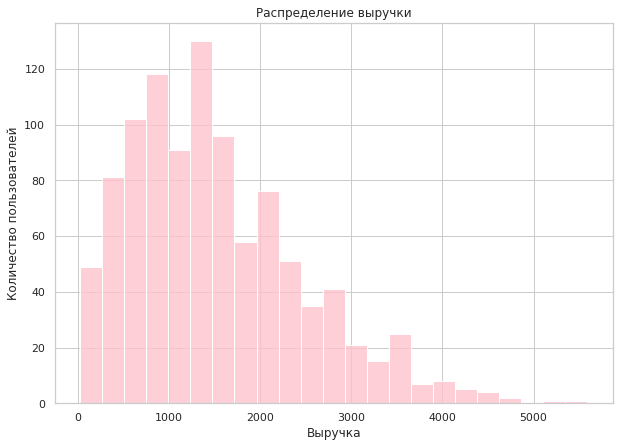

In [33]:
sns.histplot(rpu.summ, color='pink')
plt.title('Распределение выручки')
plt.xlabel('Выручка')
plt.ylabel('Количество пользователей')

График ассиметричный, проверяю тестом:

In [28]:
shapiro(rpu.summ)

ShapiroResult(statistic=0.9455310702323914, pvalue=6.696520782044877e-19)

Значение меньше 0.05, что означает ненормальное распределение переменной.

Выручка является непрерывной величиной, но распределение этой переменной ненормально, поэтому для проверки гипотезы буду использовать U-критерий Манна-Уитни:

In [29]:
mannwhitneyu(rpu.query('group == "control"').summ, 
             rpu.query('group == "experimental"').summ)

MannwhitneyuResult(statistic=73198.5, pvalue=4.991032611140459e-33)

Значение меньше 0.05, отклоняем нулевую гипотезу.

Насколько изменилась выручка в тестовой группе по сравнению с контрольной:

In [30]:
rpu \
.groupby('group', as_index = False) \
.agg({'summ': 'sum'})

,group,summ
0,control,613488.8
1,experimental,929232.0


Можно заметить, что в экспериментальной это значение значительно увеличилось.

### 2. Количество заказов на пользователя

Нулевая гипотеза: новая система рекомендаций не повлияла на количество заказов на пользователя, значимых различий между тестовой и контрольной группой нет.  
Альтернативная гипотеза: новая система повлияла на количество заказов на пользователя, есть статистически значимые различия между группами.

Создаю датафрейм с количеством заказов на каждого пользователя и группой, к которой он принадлежит.

In [31]:
orders_by_user = df \
.groupby(['user_id', 'group'], as_index = False) \
.agg({'order_id': 'count'}) \
.rename(columns={'order_id': 'orders'})
orders_by_user

,user_id,group,orders
0,964,control,2
1,965,experimental,9
2,966,control,1
3,967,experimental,5
4,968,control,3
...,...,...,...
1012,1976,experimental,5
1013,1977,experimental,4
1014,1978,experimental,7
1015,1979,experimental,6


Визуализация распределения:

/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Количество пользователей')

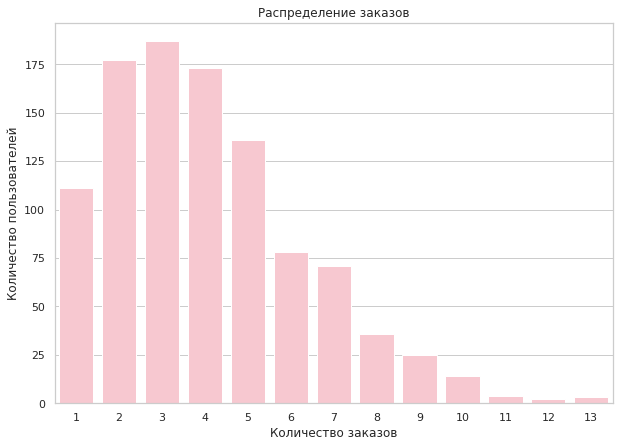

In [32]:
sns.countplot(orders_by_user.orders, color='pink')
plt.title('Распределение заказов')
plt.xlabel('Количество заказов')
plt.ylabel('Количество пользователей')

Распределение очевидно ненормальное, можно дополнительно подтвердить это тестом:

In [33]:
shapiro(orders_by_user.orders)

ShapiroResult(statistic=0.9277693033218384, pvalue=1.0314129396259515e-21)

Поэтому снова использую критерий Манна-Уитни для сравнения количества заказов между тестовой и контрольной группами:

In [34]:
mannwhitneyu(orders_by_user.query('group == "control"').orders, 
             orders_by_user.query('group == "experimental"').orders)

MannwhitneyuResult(statistic=61172.5, pvalue=6.987139829766148e-49)

Значение меньше 0.05, что позволяет отклонить нулевую гипотезу.

Насколько изменилось количество заказов в тестовой группе:

In [35]:
orders_by_user \
.groupby('group', as_index = False) \
.agg({'orders': 'sum'})

,group,orders
0,control,1609
1,experimental,2514


*А/Б-тест показал статистически значимые различий между метриками, нужными для бизнеса и пользователей.  
Средний чек увеличился, и количество заказов на пользователей тоже выросло.  
Новая система смогла принести пользу, есть основания включить её на всех пользователей.*